# Семинар 8
# Введение в стохастические методы

## Постановка задачи

$$
\min_x \sum_{i=1}^N f_i(x)
$$

- Целевая функция - сумма конечного числа функций
- $N$ может быть очень большим

### Особенности задачи

- Точное вычисление градиента занимает очень много времени
- Высокая точность решения обычно не требуется
- Допустимо введение случайности

### Градиентный спуск

$$
x_{k+1} = x_{k} - \alpha_k \sum_{i=1}^N f_i'(x_k)
$$
- $\alpha_k$ - малый шаг

## SGD

$$
x_{k+1} = x_k - \alpha_k \sum_{i \in \mathcal{I}} f'_i(x_k)
$$

- $\alpha_k = (1 - \beta)\alpha_0 + \beta \alpha_{s}$, $\beta = \frac{k}{\tau}$

Сходимость

- Для выпуклых функций $\mathcal{O}(1 / \sqrt{k})$
- Для сильно выпуклых функций $\mathcal{O}(1 / k)$

### Nesterov momentum

$$
\begin{align*}
& h_k = \beta h_{k-1} - \alpha_k \sum_{i\in \mathcal{I}} f'_i(x_k + \alpha_k h_k)\\
& x_{k+1} = x_k + h_k
\end{align*}
$$

- Не приводит к ускорению!
- Почему?

## Adagrad

\begin{align*}
& g_k = \sum_{i \in \mathcal{I}} f'_i(x_k)\\
& r = r + g_k \cdot g_k\\
& h_k = -\frac{\varepsilon}{\delta + \sqrt{r}} \cdot g_k\\
& x_{k+1} = x_k + h_k
\end{align*}

- Диагональное шкалирование градиента
- Учёт **всей** предыдущей истории для вычисления следующей точки
- Не улучшает теоретические оценки сходимости

## Adam

\begin{align*}
& g_k = \sum_{i \in \mathcal{I}} f'_i(x_k)\\
& r = \rho_2r + (1 - \rho_2) g_k \cdot g_k\\
& s = \rho_1 s + (1 - \rho_1) g_k\\
& \hat{s} = \frac{s}{1 - \rho_1^k}\\
& \hat{r} = \frac{r}{1 - \rho_2^k}\\
& h_k = -\frac{\varepsilon \hat{s}}{\delta + \sqrt{\hat{r}}} \\
& x_{k+1} = x_k + h_k
\end{align*}

## Приложения

- Всё, что связано с нейросетями
    - Компьютерное зрение
    - Обучение с подкреплением
    - GAN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, train_loader, optimizer, epoch, log_interval):
    model.train()
    current_conv = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        current_conv.append(loss)
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return current_conv

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [3]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
#                                            transforms.Normalize((0.1307,), (0.3081,))
                                           ])),
                            batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transforms.Compose([
                                       transforms.ToTensor(),
#                                        transforms.Normalize((0.1307,), (0.3081,))
                            ])),
                batch_size=16, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/Users/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729183814/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
epochs = 5
log_interval = 100
lr = 1e-3
momentum = 0.9

In [5]:
models = {
    "SGD": Net(),
    "SGD momentum": Net(),
    "Adam": Net(),
    "Adagrad": Net()
}

optimizers = {
    "SGD": optim.SGD(models["SGD"].parameters(), lr=lr),
    "SGD momentum": optim.SGD(models["SGD momentum"].parameters(), lr=lr, momentum=momentum),
    "Adam": optim.Adam(models["Adam"].parameters(), lr=lr),
    "Adagrad": optim.Adagrad(models["Adagrad"].parameters(), lr=lr)
}
conv = {opt_name: [] for opt_name in optimizers}
for opt in optimizers:
    print(opt)
    for epoch in range(1, epochs + 1):
        cur_conv = train(models[opt], train_loader, optimizers[opt], epoch, log_interval)
        conv[opt] = conv[opt] + cur_conv
#         display.clear_output(wait=True)
#         plt.plot(conv)
#     #     plt.yscale("log")
#         plt.show()
        test(models[opt], test_loader)

SGD
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327699
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.324111
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.308685
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.308652
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.305411
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.295291


/Users/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1438, Accuracy: 1150/10000 (12%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.295511
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.304995
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.311475
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.300094
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.303311
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.289284

Test set: Average loss: 0.1434, Accuracy: 1506/10000 (15%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.295503
Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.296887
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.305134
Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.299672
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.300355
Train Epoch: 3 [50000/60000 (83%)]	Loss: 2.292248

Test set: Average loss: 0.1429, Accuracy: 1939/10000 (19%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.289857
Train Epoch: 4 [10000/60000 (17%)]	Loss: 2.298115
Train Epoch: 4 [20000/60000 (33%)]	Loss: 2.305046
Train Epoch: 4 [30000/60000 (50%)]	Loss: 2.280045
Train Epoch: 4 [40000/60000 (67%

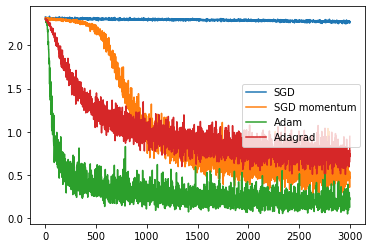

In [6]:
for opt_name in conv:
    plt.plot(conv[opt_name], label=opt_name)
plt.legend()